## Импорт всех нужных библиотек

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import glob
import re, os

from scipy.signal import savgol_filter
from math import factorial
import scipy.fftpack

import catboost as cb
from catboost import EShapCalcType, EFeaturesSelectionAlgorithm
import shap

from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.inspection import permutation_importance

## Обработка и подгрузка всех данных

In [3]:
# Указание на директорию с данными
data_dir = '/Users/bellesbae/ml_torch/covid/PPS_finale/data'

#### Использование сглаживания данных с помощью Savitzky–Golay filter ([wiki](https://en.wikipedia.org/wiki/Savitzky–Golay_filter), [paper](https://eigenvector.com/wp-content/uploads/2020/01/SavitzkyGolay.pdf))

In [4]:
def savgol(column, window, poly):
    scaler = MinMaxScaler()
    scaled_column = scaler.fit_transform(column.values.reshape(-1, 1)).flatten()

    smoothed_column = savgol_filter(scaled_column, window_length=window, polyorder=poly)
    return smoothed_column

# Экспериментальным путем было выяснено, что лучший polynom order = 5
polynom_order = 5

#### Подгрузка предиктов PINN модели

In [5]:
pinn = pd.read_csv(f'{data_dir}/pinn_pred.csv')[:260]
pinn = pinn.drop(columns=['Unnamed: 0'])

days_to_pred = 30
days_hist = 190

pinn[pinn.columns] = pinn[pinn.columns].apply(savgol, args=(days_hist+days_to_pred, polynom_order))

date_range = pd.date_range(start='2020-07-05', end='2021-03-21')
pinn.set_index(date_range, inplace=True)

pinn = pinn[:days_hist+days_to_pred]

#### Формирование датафрейма с данными Google Trends

In [6]:
trends = pd.DataFrame()
csv_files = glob.glob(f'{data_dir}/Trends/*.csv')

# Чтение всех .csv файлов из директории с трендами
for i, csv_file in enumerate(csv_files):
    temp_df = pd.read_csv(csv_file)
    new_column_name = re.findall(r"\d+", os.path.basename(csv_file))
    new_column_name = temp_df.loc['Неделя'].item().split(':')[0]
    trends[f'{new_column_name}'] = temp_df.iloc[:, 0]


# Предобработка и чистка данных
trends = trends.replace('<', '', regex=True).apply(pd.to_numeric, errors='coerce')
trends = trends.drop(['Неделя'])

trends['Date'] = trends.index
trends['Date'] = pd.to_datetime(trends['Date'])
trends['WeekStart'] = trends['Date'] - pd.to_timedelta(trends['Date'].dt.dayofweek, unit='d')

df_expanded = trends.loc[trends.index.repeat(7)].reset_index(drop=True)
df_expanded['Date'] = df_expanded['WeekStart'] + pd.to_timedelta(df_expanded.groupby('WeekStart').cumcount(), unit='d')
df_expanded.index = df_expanded.Date

df_expanded = df_expanded[(df_expanded.index < pd.to_datetime('2021-03-21'))]
trends_data = df_expanded.drop(columns=['Date', 'WeekStart'])
trends_data[trends_data.columns] = trends_data[trends_data.columns].apply(savgol, args=(days_hist+days_to_pred, polynom_order))
trends_data = trends_data.shift(2)[2:days_hist+days_to_pred+2]

#### Подгрузка исторических данных по заболеваниям

In [7]:
covid_cum_cases = pd.read_csv(f'{data_dir}/spb.combined.daily_new_new_new.txt')

covid_cum_cases['TIME'] = pd.to_datetime(covid_cum_cases['TIME.sk'])
covid_cum_cases.set_index('TIME', inplace=True)
covid_cum_cases.index = covid_cum_cases.index.date

covid_cum_cases = covid_cum_cases[(covid_cum_cases.index > pd.to_datetime('2020-05-05')) & (covid_cum_cases.index < pd.to_datetime('2021-04-29'))]

In [8]:
# Формирование целевой переменной
cb_y = covid_cum_cases['ACTIVE.sk']
cb_y = cb_y[(cb_y.index > pd.to_datetime('2020-07-04'))][:days_hist+days_to_pred]

In [9]:
# Формирование SIDR датафрейма

N = 6e6
sidr = pd.DataFrame()
sidr['I'] = covid_cum_cases['ACTIVE.sk']
sidr['R'] = covid_cum_cases['RECOVERED.sk'].cumsum()
sidr['D'] = covid_cum_cases['DEATHS.sk'].cumsum()
sidr['S'] = N - sidr['I'] - sidr['D'] - sidr['R']
sidr.index = covid_cum_cases.index

sidr = sidr[:days_hist+days_to_pred]
sidr[sidr.columns] = sidr[sidr.columns].apply(savgol, args=(days_hist+days_to_pred, polynom_order))

### Собираем финальный датасет и сдвигаем часть данных из предсказания PINN модели

In [10]:
pinn = pinn.reset_index(drop=True)
sidr = sidr.reset_index(drop=True)
trends_data = trends_data.reset_index(drop=True)

df_cb = pd.concat([sidr, trends_data], axis=1)

df_cb[['S_pinn', 'I_pinn', 'D_pinn', 'R_pinn']] = pinn
df_cb

,I,R,D,S,локдаун,головная боль,карантин,слабость,тест на ковид,спб ковид,...,турецкие сериалы,ковид симптомы,ковид,скорая помощь,ибупрофен,онлайн игры,S_pinn,I_pinn,D_pinn,R_pinn
0,-0.006611,-0.015073,0.014078,1.011409,0.002004,0.592187,0.882386,0.300095,0.068703,0.052098,...,0.412721,0.128575,0.117832,0.196889,0.321679,1.123422,0.995374,0.003578,0.002520,0.008168
1,0.003360,-0.013413,0.010488,1.006730,0.004807,0.591830,0.873686,0.304069,0.078253,0.069507,...,0.395622,0.163259,0.135614,0.183293,0.316496,1.082597,0.995868,0.002925,0.005168,0.007139
2,0.012655,-0.011645,0.007367,1.002231,0.007393,0.591311,0.864522,0.307903,0.087315,0.085855,...,0.379294,0.196067,0.152342,0.170752,0.311695,1.043360,0.996261,0.002478,0.007753,0.006236
3,0.021301,-0.009773,0.004699,0.997907,0.009769,0.590633,0.854921,0.311595,0.095899,0.101174,...,0.363718,0.227058,0.168045,0.159219,0.307265,1.005662,0.996558,0.002223,0.010276,0.005452
4,0.029323,-0.007799,0.002469,0.993750,0.011944,0.589803,0.844910,0.315146,0.104020,0.115495,...,0.348878,0.256290,0.182752,0.148647,0.303192,0.969455,0.996766,0.002145,0.012738,0.004782
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,0.897955,0.899339,0.953568,0.099202,0.364706,0.556578,0.071150,0.504879,0.890265,0.808488,...,0.583732,0.459188,0.925936,0.363691,0.584127,0.557413,0.285100,0.978248,0.720970,0.663699
216,0.932752,0.922741,0.964323,0.071852,0.361877,0.556362,0.069195,0.502674,0.887208,0.804155,...,0.588615,0.456741,0.921548,0.357433,0.583957,0.556296,0.278040,0.973742,0.727184,0.671832
217,0.968843,0.946801,0.975119,0.043621,0.358850,0.556058,0.067280,0.500456,0.883831,0.799566,...,0.593396,0.454091,0.916831,0.351070,0.583657,0.555117,0.271023,0.968824,0.733399,0.679947
218,1.006263,0.971531,0.985950,0.014488,0.355630,0.555669,0.065405,0.498230,0.880137,0.794726,...,0.598069,0.451240,0.911792,0.344610,0.583226,0.553884,0.264047,0.963499,0.739613,0.688045


## Находим лучшие параметры для модели с помощью GridCrossValidation

In [11]:
X_train_gcv, X_test_gcv, y_train_gcv, y_test_gcv = train_test_split(df_cb, cb_y, test_size=days_to_pred/(days_hist+days_to_pred), random_state=42, shuffle=False)

y_scaler_gcv = MinMaxScaler()
y_train_scaled_gcv = y_scaler_gcv.fit_transform(y_train_gcv.values.reshape(-1, 1)).flatten()

train_dataset_gcv = cb.Pool(X_train_gcv, y_train_scaled_gcv)
test_datase_gcvt = cb.Pool(X_test_gcv, y_test_gcv)

In [12]:
model_gcv = cb.CatBoostRegressor(loss_function='MAPE', random_seed=42)

grid = {'iterations': [1300, 1500],
        'learning_rate': [0.1, 0.13],
        'depth': [2, 3, 4, 6],
        'l2_leaf_reg': [0.12, 0.15]}

Grid_CBC = GridSearchCV(estimator=model_gcv, param_grid=grid, n_jobs=-1)
Grid_CBC.fit(X_train_gcv, y_train_scaled_gcv, silent=True)

print("Results from Grid Search " )
print("The best parameters across ALL searched params: ", Grid_CBC.best_params_)

Results from Grid Search 
The best parameters across ALL searched params:  {'depth': 2, 'iterations': 1500, 'l2_leaf_reg': 0.15, 'learning_rate': 0.1}


In [13]:
gcv_best_model = cb.CatBoostRegressor(**Grid_CBC.best_params_, loss_function='MAPE', random_seed=42)

gcv_best_model.fit(X_train_gcv, y_train_scaled_gcv, silent=True)
best_model_pred_gcv = y_scaler_gcv.inverse_transform(gcv_best_model.predict(X_test_gcv).reshape(-1, 1))

gcv_mape = mean_absolute_percentage_error(y_test_gcv, best_model_pred_gcv)
gcv_rmse = np.sqrt(mean_squared_error(y_test_gcv, best_model_pred_gcv))

print('Testing performance')
print('MAPE: {:.2f}'.format(gcv_mape))
print('RMSE: {:.2f}'.format(gcv_rmse))

Testing performance
MAPE: 0.04
RMSE: 3939.66


<function matplotlib.pyplot.show(close=None, block=None)>

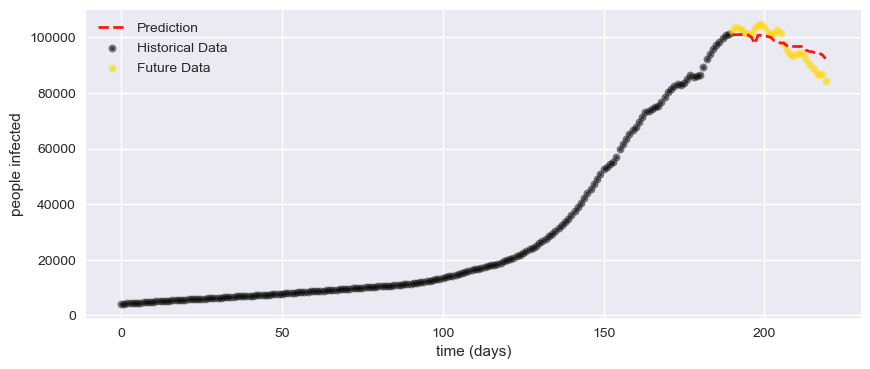

In [14]:
plt.style.use("seaborn")
plt.figure(figsize=(10,4))

plt.scatter(list(df_cb.index)[:len(y_train_gcv)], y_train_gcv.values, c = 'black', alpha=0.5, lw=3, s=7, label='Historical Data')
plt.scatter(list(df_cb.index)[len(y_train_gcv):], y_test_gcv.values, c = 'gold', alpha=0.5, lw=3, s=7, label='Future Data')
plt.plot(list(df_cb.index)[len(y_train_gcv):], best_model_pred_gcv, 'red', alpha=0.9, lw=2, label='Prediction', linestyle='dashed')

plt.xlabel('time (days)')
plt.ylabel('people infected')

plt.legend()
plt.show

## Отбор признаков с помощью catboost.select_features

In [20]:
X_train_sf, X_test_sf, y_train_sf, y_test_sf = train_test_split(df_cb, cb_y, test_size=days_to_pred/(days_hist+days_to_pred), random_state=42, shuffle=False)

y_scaler_sf = MinMaxScaler()
y_train_scaled_sf = y_scaler_sf.fit_transform(y_train_sf.values.reshape(-1, 1)).flatten()
y_test_scaled_sf = y_scaler_sf.fit_transform(y_test_sf.values.reshape(-1, 1)).flatten()

train_dataset_sf = cb.Pool(X_train_sf, y_train_scaled_sf)
test_dataset_sf = cb.Pool(X_test_sf, y_test_scaled_sf)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

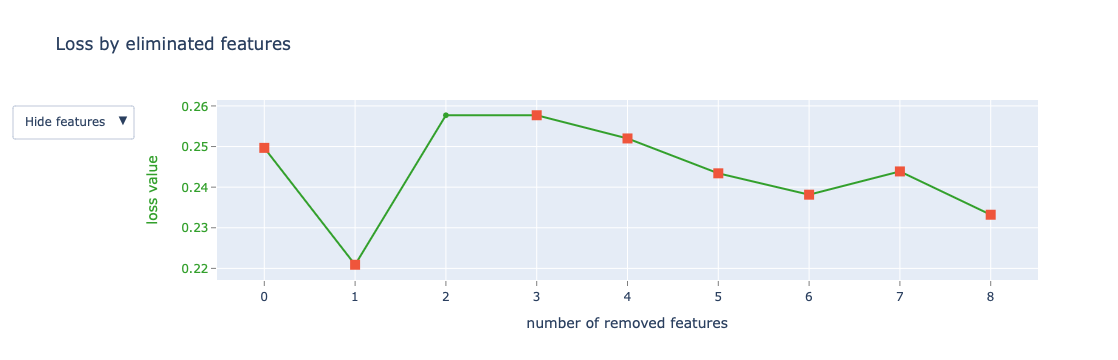

In [21]:
model_sf = cb.CatBoostRegressor(**Grid_CBC.best_params_, loss_function='MAPE', random_seed=42)

summary = model_sf.select_features(
    train_dataset_sf,
    eval_set=test_dataset_sf,
    features_for_select=df_cb.columns,
    num_features_to_select=24,
    steps=7,
    algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues,
    shap_calc_type=EShapCalcType.Regular,
    train_final_model=True,
    logging_level='Silent',
    plot=True
)

In [22]:
print(f'Самые важные признаки\n', *summary["selected_features_names"])
print()
print(f'Самые ненужные признаки\n', *summary['eliminated_features_names'])

Самые важные признаки
 D S головная боль слабость спб ковид прививки таблетки от температуры терафлю pornhub ковид как лечить ковид смертность как лечиться от ковида что пить при ковиде как лечить ковид ковид что пить турецкие сериалы ковид симптомы ковид скорая помощь ибупрофен онлайн игры I_pinn D_pinn R_pinn

Самые ненужные признаки
 карантин S_pinn локдаун I R тест на ковид тест на антитела сериалы


In [23]:
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(df_cb[summary['selected_features_names']], cb_y, test_size=days_to_pred/(days_hist+days_to_pred), random_state=42, shuffle=False)

y_scaler_final = MinMaxScaler()
y_train_scaled_final = y_scaler_final.fit_transform(y_train_final.values.reshape(-1, 1)).flatten()

In [24]:
final_model = cb.CatBoostRegressor(**Grid_CBC.best_params_, 
                                   loss_function='MAPE',
                                   random_seed=42, 
                                   train_dir=f"{data_dir}plot_loss")

final_model.fit(X_train_final, y_train_scaled_final, silent=True)
final_model_pred = y_scaler_final.inverse_transform(final_model.predict(X_test_final).reshape(-1, 1))

mape_final = mean_absolute_percentage_error(y_test_final, final_model_pred)
rmse_final = np.sqrt(mean_squared_error(y_test_final, final_model_pred))

print('Testing performance')
print('MAPE: {:.2f}'.format(mape_final))
print('RMSE: {:.2f}'.format(rmse_final))

Testing performance
MAPE: 0.03
RMSE: 3555.63


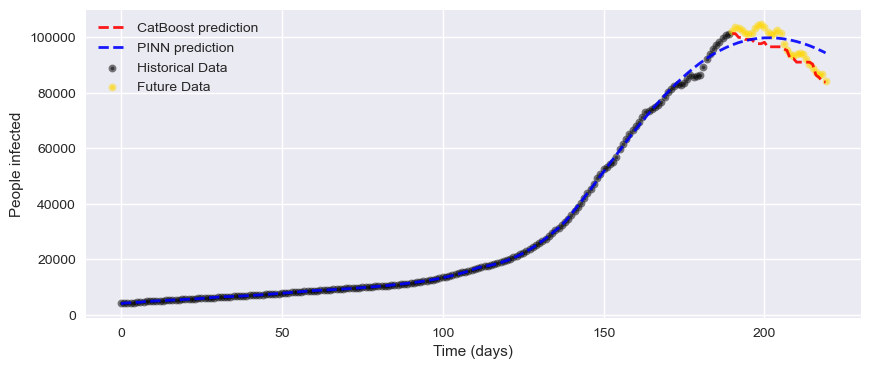

In [28]:
plt.style.use("seaborn")
plt.figure(figsize=(10,4))

plt.scatter(list(df_cb.index)[:len(y_train_gcv)], y_train_final.values, c='black', alpha=0.5, lw=3, s=7, label='Historical Data')
plt.scatter(list(df_cb.index)[len(y_train_gcv):], y_test_final.values, c='gold', alpha=0.5, lw=3, s=7, label='Future Data')
plt.plot(list(df_cb.index)[len(y_train_gcv):], final_model_pred, c='red', alpha=0.9, lw=2, label='СatBoost prediction', linestyle='dashed')
plt.plot(list(df_cb.index), pd.read_csv(f'{data_dir}/pinn_pred.csv')['I'][:220].values, c='blue', alpha=0.9, lw=2, label='PINN prediction', linestyle='dashed')

plt.xlabel('Time (days)')
plt.ylabel('People infected')

plt.legend()
plt.show
plt.savefig('end_graph.png',dpi=800)

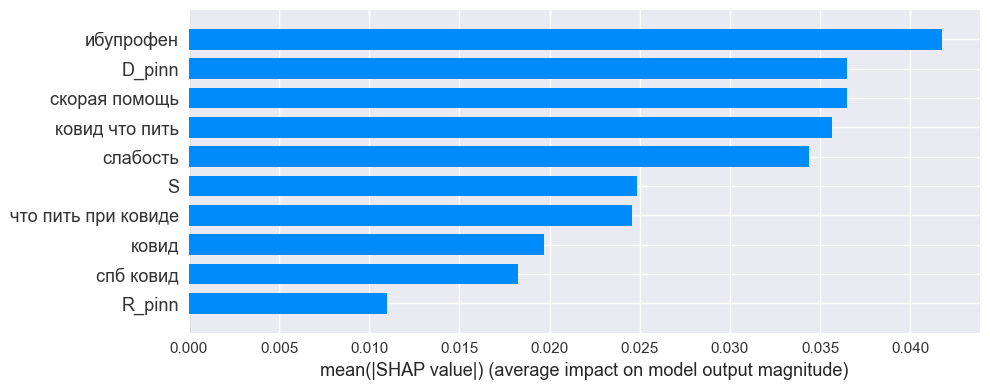

In [29]:
shap.initjs()

explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(df_cb[summary['selected_features_names']])
shap.summary_plot(shap_values, df_cb[summary['selected_features_names']], feature_names=X_test_final.columns, max_display=10, plot_type='bar', plot_size=(10,4))